# Character classification using NNs with PyTorch

Jake Dame

26 Jul 2024

## Setup

In [207]:
import matplotlib.pyplot as plt  # For plotting

import numpy as np  # For numpy arrays

import pandas as pd  # For csv and df manipulation

import random  # For getting random images out of certain lists of images; and for getting random Gaussian vals

from sklearn.model_selection import train_test_split # For splitting into training/testing data
from sklearn.preprocessing import scale  # For min-max scaling x-values

import torch  # For tensors
import torch.nn as nn  # For nn class
import torch.nn.functional as F  # For ReLU, Softmax
import torch.optim as optim  # For Adam optimizer
from torch.utils.data import DataLoader, TensorDataset  # For dataloader, TensorDataset
from torch.utils.data.dataloader import default_collate # For gpu stuff

# Device stuff.
gpu = False
if gpu:
	# "mps" ==> "multiprocess service"
	device = ("mps" if torch.backends.mps.is_available() else "cpu")
else:
	device = "cpu"

# Hyperparameters stuff.
batch_size = 8  # For dataloader/batcher
epochs = 8  # For train() for-loop
learning_rate = 1e-4  # For Adam optimizer
loss_function_cnn = nn.CrossEntropyLoss()
loss_function_autoencoder = nn.MSELoss()  # Mean-Squared Error loss ==> OLS divided by the number of data points
test_size = 0.2  # test_train_split

## FontDataset

In [208]:
class FontDataset:
	"""Class that encapsulates various useful attributes and methods of a 
	UC Irvine character/font dataset
	"""

	def __init__(self, fonts: list):
		# Python version of a polymorphic constructor: can provide "ARIAL" or ["ARIAL, "TIMES", "BROADWAY"]
		if isinstance(fonts, str):
			self.fonts = fonts
			self.df = pd.read_csv(f"character+font+images/{self.fonts}.csv")
		elif isinstance(fonts, list):
			self.fonts = fonts
			list_of_dfs = [pd.read_csv(f"character+font+images/{f}.csv") for f in self.fonts]
			df = pd.concat(list_of_dfs)

			# This de-index-boundifies the dataframe and shuffles it so we don't have parameters
			# being trained on large contiguous chunks of one dataset before moving to another.
			self.df = df.sample(frac=1).reset_index(drop=True)

		# Used to assign number of nodes in output layer for a net
		self.num_classes = len(self.df["m_label"].unique())

		# numpy arrays; label<->index conversion dictionaries
		self.Xs, self.Xs_unscaled, self.Xs_noisy = self.get_Xs()
		self.ys, self.codepoint_to_ix, self.ix_to_codepoint = self.get_ys()

		# Datasets
		self.train_set, self.test_set, self.train_set_noisy, self.test_set_noisy = self.get_tensors()

		self.num_samples_total = self.df.shape[0]
		self.num_samples_train = len(self.train_set)
		self.num_samples_test = len(self.test_set)

		# These are only filled in if `evaluate()` is used with the FontDataset instance
		self.misclassifications = []
		self.low_confidences = []
	
	def get_Xs(self):
		"""Returns 'numSamples x w x h' numpy array of scaled, unscaled, and scaled+noisy Xs"""
		
		# Create list with all the "r{x}c{y}" column (name)s; get numpy array from them
		r_cols = [col for col in self.df.columns if col.startswith('r')]
		unscaled_pixel_vals = self.df[r_cols].values

		# Normalize pixel values in the array
		scaled_pixel_vals = scale(unscaled_pixel_vals)

		# Add Gaussian noise
		noise = np.random.normal(scale=np.std(unscaled_pixel_vals) ,size=unscaled_pixel_vals.shape)
		noisy = unscaled_pixel_vals + noise
		noisy = scale(noisy)

		# Normalize and reshape into numpy arrays
		return (np.reshape(scaled_pixel_vals, (-1, 20, 20)),
			    np.reshape(unscaled_pixel_vals, (-1, 20, 20)),
			    np.reshape(noisy, (-1, 20, 20)))

	def get_ys(self):
		"""Returns numpy array of labels (i.e. target values).
		Indexes the unicode codepoint values in the 'm_label' column  of the pandas data frame to 
		bridge the large gaps between clusters of codepoint values in certain fonts/sets of chars.
		"""

		# Get the unique label values
		codepoint_values = set(self.df["m_label"])

		# Create dictionary (key-value pairs) of codepoint-value-to-index mappings
		codepoint_to_ix = {val: ix for ix, val in enumerate(codepoint_values)}

		# And vice-versa, to convert back later (for display, etc.)
		ix_to_codepoint = {ix: val for val, ix in codepoint_to_ix.items()}

		# Remap the 'm_label' column with contiguous index values
		remapped_labels = [codepoint_to_ix[key] for key in self.df["m_label"]]

		# Convert to 1D numpy array
		return np.array(remapped_labels), codepoint_to_ix, ix_to_codepoint  
	
	def get_tensors(self):
		"""Splits into training/testing datasets; returns TensorDataset objects for
		both normal (CNN) and noised (autoencoder) datasets
		"""

		# Get tensors
		Xs_tensor = torch.tensor( self.Xs.reshape(-1, 1, 20, 20), dtype=torch.float32 )
		ys_tensor = torch.tensor( self.ys, dtype=torch.long )

		# Get training and testing data split up
		X_train, X_test, y_train, y_test = train_test_split(Xs_tensor, ys_tensor, 
													        test_size=test_size, random_state=137)

		# Get TensorDataset objects
		train_set = TensorDataset(X_train, y_train)
		test_set = TensorDataset(X_test, y_test)

		Xs_tensor_noisy = torch.tensor( self.Xs_noisy.reshape(-1, 1, 20, 20), dtype=torch.float32 )
		ys_tensor_noisy = torch.tensor( self.ys, dtype=torch.long )
		X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(Xs_tensor_noisy, ys_tensor_noisy, 
															                        test_size=test_size, random_state=137)
		train_set_noisy = TensorDataset(X_train_noisy, y_train_noisy)
		test_set_noisy = TensorDataset(X_test_noisy, y_test_noisy)

		return train_set, test_set, train_set_noisy, test_set_noisy

	def describe(self):
		"""Just shows a bunch of stuff about a FontDataset instance"""

		# Number of samples and number of unique labels/classes
		print("Num samples/images: ", self.num_samples_total)
		print("Num unique classes of character: ", self.num_classes)

		Xs_indices = random.sample(range(len(self.Xs)), 25)  # Get 25 random indices
        
		# `imshow()` for unscaled and scaled images
		plt.figure(figsize=(5, 5))
		for i, sample_no in enumerate(Xs_indices):
			unscaled_image = np.reshape(self.Xs_unscaled[sample_no], (20, 20))
			plt.subplot(5, 5, i+1)
			plt.imshow(unscaled_image, cmap='Greys', interpolation='none')
			plt.axis('off')
		plt.suptitle(f"25 Random Unscaled Images from UC Irvine '{self.fonts}' Dataset")
		plt.show()

		# `imshow()` for scaled images
		plt.figure(figsize=(5, 5))
		for i, sample_no in enumerate(Xs_indices):
			scaled_image = np.reshape(self.Xs[sample_no], (20, 20))
			plt.subplot(5, 5, i+1)
			plt.imshow(scaled_image, cmap='Greys', interpolation='none')
			plt.axis('off')
		plt.suptitle(f"25 Random Scaled Images from UC Irvine '{self.fonts}' Dataset")
		plt.show()

		# `imshow()` for noised images
		plt.figure(figsize=(5, 5))
		for i, sample_no in enumerate(Xs_indices):
			scaled_image = np.reshape(self.Xs_noisy[sample_no], (20, 20))
			plt.subplot(5, 5, i+1)
			plt.imshow(scaled_image, cmap='Greys', interpolation='none')
			plt.axis('off')
		plt.suptitle(f"25 Random Noised Images from UC Irvine '{self.fonts}' Dataset")
		plt.show()

	def show_misclassifications(self):
		"""Displays 25 of the misclassifications from this dataset"""

		if not self.misclassifications: 
			return "Must `evaluate()` this dataset first"
		
		# Get 25 random images from misclassifications, and then sort
		# them in descending order by confidence (3rd element in the tuple)
		random_low_confidences = random.sample(self.low_confidences, 25)
		random_low_confidences.sort(key=lambda x: x[3], reverse=True)

		plt.figure(figsize=(10, 10))

		for i in range(25):
			char_image, pred_y, actual_y = self.misclassifications[i]
			pred_y = self.ix_to_codepoint[pred_y]
			actual_y = self.ix_to_codepoint[actual_y]

			plt.subplot(5, 5, i + 1)
			plt.imshow(char_image.reshape(20, 20), cmap='Greys', interpolation='none')
			plt.title(f"Predicted: '{chr(pred_y)}' \n Actual: '{chr(actual_y)}'")
			plt.axis('off')

			# This prevents overlapping captions
			plt.tight_layout(rect=[0, 0.03, 1, 0.95])

		plt.suptitle(f"25 Random Misclassifications for the '{self.fonts}' Set")
		plt.show()

	def show_low_confidences(self):
		"""Displays 25 of the low confidence (<0.5) predictions from this dataset"""

		random_low_confidences = random.sample(self.low_confidences, 25)
		random_low_confidences.sort(key=lambda x: x[3], reverse=True)

		plt.figure(figsize=(8, 8))

		for i in range(25):
			char_image, pred_y, actual_y, confidence = random_low_confidences[i]
			# pred_y = self.ix_to_codepoint.get(int(pred_y))
			# actual_y = self.ix_to_codepoint.get(int(actual_y))
			pred_y = self.ix_to_codepoint[int(pred_y)]
			actual_y = self.ix_to_codepoint[int(actual_y)]

			plt.subplot(5, 5, i + 1)
			plt.imshow(char_image.reshape(20, 20), cmap='Greys', interpolation='none')
			plt.title(f"Predicted: '{chr(pred_y)}' \n Actual: '{chr(actual_y)}' \n Confidence: {confidence: .2f}")

			plt.axis('off')

		plt.suptitle(f"25 Random Misclassifications and Confidence Levels for the '{self.fonts}' dataset")
		plt.tight_layout(rect=[0, 0.03, 1, 0.95])
		plt.show()

## CNNOriginal

This is the CNN as specified in the assignment instructions. The goal will be to improve upon this one.

In [209]:
class CNNOriginal(nn.Module):
	"""Define a CNN class which inherits from PyTorch's nn class
	Includes a constructor that defines the shapes of the convolution, pooling, and fully-connected layers
	Includes a `forward()` method that defines the order of layers and application of activation functions
	"""

	def __init__(self, outputs: int):
		"""TODO write this"""

		super(CNNOriginal, self).__init__()

		color_channels = 1 # 1 for grayscale

		conv1_O = 6
		conv2_O = 16
		pooled_O = conv2_O * 3 * 3
		fc1_O = 120
		fc2_O = outputs

		self.conv1 = nn.Conv2d(in_channels=color_channels, 
						 	   out_channels=conv1_O, 
							   kernel_size=3)
		
		self.conv2 = nn.Conv2d(in_channels=conv1_O, 
						 	   out_channels=conv2_O, 
							   kernel_size=3)
		
		self.pool = nn.MaxPool2d(kernel_size=2, 
						   	     stride=2)

		self.fc1 = nn.Linear(in_features=pooled_O, 
					   	     out_features=fc1_O)

		self.fc2 = nn.Linear(in_features=fc1_O, 
					   	     out_features=fc2_O)
	
	def forward(self, x):
		"""x is a tensor containing a batch (of images) with dimensions: #BATCH_SIZE x W x H x #CHANNELS
   		Returns a 1D tensor of raw output values
		"""

		# print_stuff = False
		# if print_stuff: print("At start:\t", x.shape) # 20 x 20 x 1

		x = F.relu( self.conv1(x) )
		# if print_stuff: print("After conv1:\t", x.shape) # 18 x 18 x 1
		x = self.pool(x)
		# if print_stuff: print("After pool1:\t", x.shape) # 9 x 9 x 1

		x = self.conv2(x)
		# if print_stuff: print("After conv2:\t", x.shape) # 7 x 7 x 1
		x = self.pool(x)
		# if print_stuff: print("After pool2:\t", x.shape) # 3 x 3 x 1

		x = x.view( x.shape[0], -1 ) # flatten
		# if print_stuff: print("After flatten:\t", x.shape) # 144 x 1

		x = F.relu( self.fc1(x) )
		# if print_stuff: print("After fc1:\t", x.shape) # 120 x 1
		x = self.fc2(x)
		# if print_stuff: print("After fc2:\t", x.shape) # 3098 x 1

		return x

## CNNImproved

In [210]:
class CNNImproved(nn.Module):
	def __init__(self, outputs: int):
		super(CNNImproved, self).__init__()

		conv1_out = 24
		conv2_out = 48
		poold_out = (3 * 3) * conv2_out
		fc1_out = 1500
		fc2_out = outputs

		self.conv1 = nn.Conv2d(in_channels=         1, out_channels= conv1_out, kernel_size= 5)
		self.conv2 = nn.Conv2d(in_channels= conv1_out, out_channels= conv2_out, kernel_size= 3)

		self.fc1 = nn.Linear(in_features= poold_out,  out_features= fc1_out)
		self.fc2 = nn.Linear(in_features= fc1_out,    out_features= fc2_out)

		self.batch1 = nn.BatchNorm2d(num_features= conv1_out)
		self.batch2 = nn.BatchNorm2d(num_features= conv2_out)

		self.pool = nn.MaxPool2d(kernel_size= 2, stride= 2)

		self.dropout = nn.Dropout(p= 0.1)

	def forward(self, x):
		print_stuff = False

		x = self.conv1(x)
		x = self.batch1(x)
		x = F.relu(x)
		if print_stuff: print("After conv1:\t", x.shape)
		x = self.pool(x)
		if print_stuff: print("After pool1:\t", x.shape)

		x = self.conv2(x)
		x = self.batch2(x)
		x = F.relu(x)
		if print_stuff: print("After conv2:\t", x.shape)
		x = self.pool(x)
		if print_stuff: print("After pool2:\t", x.shape)

		x = x.view(x.shape[0], -1) # flatten

		x = self.fc1(x)
		x = F.relu(x)
		x = self.dropout(x)
		
		return self.fc2(x)

## train()

In [211]:
def train(net, font: FontDataset, epochs: int):
	if gpu:
		dataloader = DataLoader(font.train_set, batch_size=batch_size, 
						        shuffle=True, num_workers=0, 
								collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
	else:
		dataloader = DataLoader(font.train_set, batch_size=batch_size, 
						        shuffle=True, num_workers=0)
		
	optimizer = optim.Adam(net.parameters(), lr=learning_rate)

	# Outer loop runs an epoch (of batches); inner loop runs batches.
	for epoch in range(epochs):

		running_loss = 0.0
		for i, data_ in enumerate(dataloader):

			# Zero out the parameter gradients (they are retained by the optimizer).
			optimizer.zero_grad()

			# Get the Xs (images), ys (labels) data as [Xs, ys].
			xs, actual_ys = data_

			# Forward + backward + optimize.
			raw_outputs = net(xs)

			# This does Softmax and then CE for us.
			loss = loss_function_cnn(raw_outputs, actual_ys) 

 			# See how to change the weights to do better
			loss.backward()

			 # And tell optimizer to actually change the weights
			optimizer.step()

			running_loss += loss.item() # print stuff every 2000 mini-batches
			if i % 2000 == 1999:    
				print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
				running_loss = 0.0

## evaluate()

In [212]:
def evaluate(net, font: FontDataset):
	if gpu:
		dataloader = DataLoader(font.train_set, batch_size=batch_size, 
						        shuffle=True, num_workers=0, 
								collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
	else:
		dataloader = DataLoader(font.train_set, batch_size=batch_size, 
						        shuffle=True, num_workers=0)

	correct = 0
	total = 0

	# This like a C# `using` block; says "I already have optimals, run w/out grad descent"
	with torch.no_grad(): 
		for data_ in dataloader:
			xs, actual_ys = data_
			raw_outputs = net(xs)

			# Just grab the top prediction
			_, pred_ys = torch.max(raw_outputs.data, 1) 
			total += actual_ys.size(0)
			correct += (pred_ys == actual_ys).sum().item()

			# fill up FontDataset object's misclassifications list
			font.misclassifications += [ ( xs[i], pred_ys[i].item(), actual_ys[i].item() )
										   for i in range( len(pred_ys) ) 
										   if pred_ys[i] != actual_ys[i] ]
			
			# fill up FontDataset object's confidences list
			confs_list = F.softmax(raw_outputs, 1)
			max_confs, _ = torch.max(confs_list, 1)
			font.low_confidences += [ ( xs[i], pred_ys[i].item(), actual_ys[i].item(), max_confs[i].item() )
									    for i in range(len(max_confs))  
										if max_confs[i] < 0.5 ]

	# Just do a coarse evaluation... how many did we predict correctly?
	print('Accuracy: %d %%' % (100*correct / total))

## Step 1: Data Acquisition + Cleanup + Exploration

Num samples/images:  2668
Num unique classes of character:  667


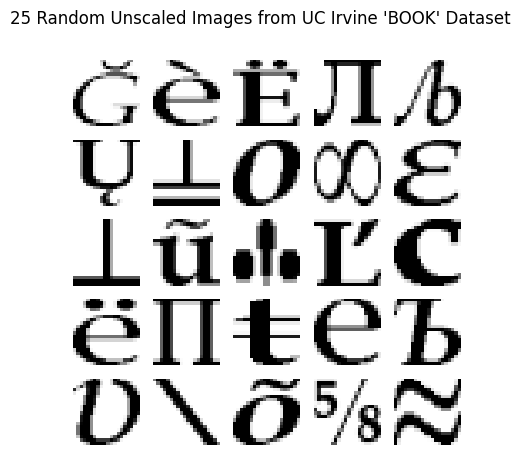

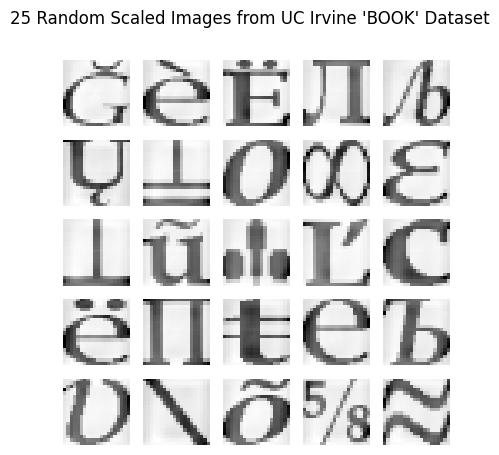

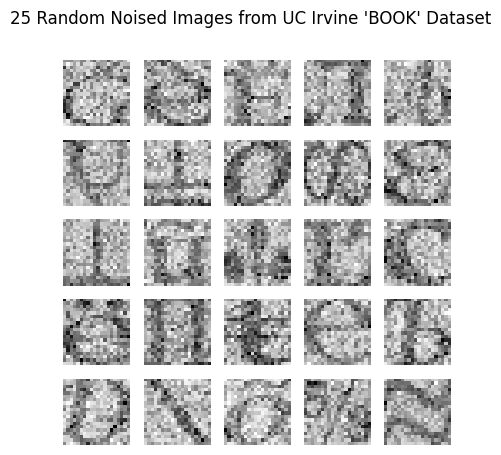

In [213]:
arial_font = FontDataset("BOOK")

arial_font.describe()

## Step 2: Build and train a Pytorch CNN

In [214]:
# This line is reproduced here for easier iterative exploration
font_original = FontDataset("ARIAL")

cnn_original = CNNOriginal(outputs=font_original.num_classes).to(device=device)

print("Device:\t\t\t", f"'{device}'",
	  "\nFont:\t\t\t", font_original.fonts,
	  "\nNum total samples:\t", font_original.num_samples_total,
	  "\nNum training samples:\t", font_original.num_samples_train,
	  "\nNum testing samples:\t", font_original.num_samples_test)

# Train the network
train(cnn_original, font_original, epochs=epochs)

# Get a measure of accuracy for the model produced by the network
evaluate(cnn_original, font_original)

Device:			 'cpu' 
Font:			 ARIAL 
Num total samples:	 26237 
Num training samples:	 20989 
Num testing samples:	 5248
[1,  2000] loss: 6.610
[2,  2000] loss: 4.699
[3,  2000] loss: 3.724
[4,  2000] loss: 2.938
[5,  2000] loss: 2.395
[6,  2000] loss: 1.990
[7,  2000] loss: 1.769
[8,  2000] loss: 1.576
Accuracy: 62 %


### Analysis

After running a few times for the "ARIAL" dataset, and 4 epochs, accuracy on this original net is between 60%. The "ARIAL" dataset has just over 26,000 samples

Doubling epochs (to 8) increases accuracy about 5-10%.

As can be seen in the class defintion, this net has:
+ 2 convolutional layers, training 12 and then 24 filters, respectively
+ 2 full-connected layers

There is no use of batch normalization or dropout.

As was specified (unless I misinterpreted), the ReLU activation funtion was only applied to the first convolutional layer and first fully-connected layer.

I've tried this on smaller datasets and the accuracy is very bad; the "VIVALDI" font has only ≈1000 samples and it's accuracy never leaves the single digits.

## Step 3: Exploration and Evaluation

In [215]:
cnn_improved = CNNImproved(outputs=font_original.num_classes).to(device=device)

print("Device:\t\t\t", f"'{device}'",
	  "\nFont:\t\t\t", font_original.fonts,
	  "\nNum total samples:\t", font_original.num_samples_total,
	  "\nNum training samples:\t", font_original.num_samples_train,
	  "\nNum testing samples:\t", font_original.num_samples_test)

train(cnn_improved, font_original, epochs=epochs)
evaluate(cnn_improved, font_original)

Device:			 'cpu' 
Font:			 ARIAL 
Num total samples:	 26237 
Num training samples:	 20989 
Num testing samples:	 5248
[1,  2000] loss: 4.952
[2,  2000] loss: 2.141
[3,  2000] loss: 1.196
[4,  2000] loss: 0.886
[5,  2000] loss: 0.752
[6,  2000] loss: 0.663
[7,  2000] loss: 0.596
[8,  2000] loss: 0.546
Accuracy: 84 %


### Analysis

**Notes on creating an improved CNN:**

I experimented with:
+ Number of filters ==> feature maps for the convolutional layers
+ Number of convolutional layers
+ Convolutional kernel size (3x3 vs. 5x5)
+ Fully-connected shapes (number of nodes each)
+ Number of fully-connected layers
+ Applying the activation function in different places
+ Pooling selectively (not after every convolutional layer)

In the end, my best network was able to predict with around 85% accuracy, which I was pretty proud of, especially doing it with only 8 epochs, and not adding any layers. (This was after many, many hours trying to find a good network):
+ I increased the kernel size to 5x5 in the first convolutional layer (but kept the second at 3x3)
+ I doubled the number of filters in the convolutional layers (12 ==> 24; 24 ==> 48)
+ Largely increased number of nodes in the first fully-connected layer. This, because some of the character datasets had over 3000 unique classes.
+ I experimented with adding layers, but, in the end, found that 2 conv./pool layers and 2 FC layers did the trick.

I did not experiment with:
+ MaxPooling stuff (pooling window size; stride)

A bunch of hyperparameters stuff I experimented with a little, but kept it consistent between both classes because I was trying to get a fair comparison between the CNNOriginal and CNNImproved classes (that's why they are "global" variables at the top of the file). I did not see a huge difference in altering, but, I did not really give it a fair chance (I did not spend much time tuning these):
  + Batch size (kept this at 8)
  + Learning rate
  + Test/train split (kept this at 80/20)

I did not really experiment with padding, thus:
+ If starting with 20 x 20, we don't have a TON of room to downsample (without padding). Adding a third conv/pool layer is tough (the pool layer would be selecting a max of a 1 x 1 x 1 array, which usually did terrible - at least for my experiments); increasing the filter size to 5 x 5 is also tough. I would explore more with padding in the future.
  
Observations:  
+ The size and quantity of the fully-connected layers adds way, way more to running time than convolutional stuff.
+ I tried one with 12000 nodes in the first fc layer and it took 7 minutes to get through 2000 mini batches so I did not continue down this path

Things that I did not experiment with that I would in the future mostly involve hyperparameter stuff, padding, and:
+ Since we are trying to recognize a single character, and not a huge complex image, increasing resolution probably wouldn't do all that much (like a 500 x 500 resolution image of a character). At least I don't think.

In [216]:
imposter_font = FontDataset("BOOK")

evaluate(cnn_improved, imposter_font)

Accuracy: 0 %


### Analysis

**"Test the accuracy of your network with character inputs from a DIFFERENT font set. How does it perform?"**

Very poorly. I tried this with some different pairings, but rarely got anything "good". If trained on a "weird" font (or vice versa), it was especially bad. Fonts can display the same character with a huge amount of variety (thickness, serifs, etc.), and it's no sweat for our eyes/brains. But the CNN... not so much, apparently (unless I did not experiment well enough. Also, I imagine even my best network is pretty primitive). So, the similarity of the stylization of the font seems to be important here.

### Analysis

**"What accuracy do you see when testing with inputs from a font you didn't train on?"**

0%. This is probably something to do with the "neural nets are really good at mimicking their training data" thing. (Except these particular nets aren't what I would call really good at doing even that).

In [217]:
font_multiple = FontDataset(["ARIAL", "TIMES"])

cnn_improved_multiple = CNNImproved(font_multiple.num_classes)

print("Device:\t\t\t", f"'{device}'",
	  "\nFont:\t\t\t", font_multiple.fonts,
	  "\nNum total samples:\t", font_multiple.num_samples_total,
	  "\nNum training samples:\t", font_multiple.num_samples_train,
	  "\nNum testing samples:\t", font_multiple.num_samples_test)

train(cnn_improved_multiple, font_multiple, epochs=epochs)
evaluate(cnn_improved_multiple, font_multiple)

Device:			 'cpu' 
Font:			 ['ARIAL', 'TIMES'] 
Num total samples:	 38967 
Num training samples:	 31173 
Num testing samples:	 7794
[1,  2000] loss: 5.627
[2,  2000] loss: 1.888
[3,  2000] loss: 1.189
[4,  2000] loss: 0.993
[5,  2000] loss: 0.853
[6,  2000] loss: 0.759
[7,  2000] loss: 0.686
[8,  2000] loss: 0.624
Accuracy: 81 %


### Analysis

**"Train your best network on inputs from the data from at least 2 different fonts. How does your accuracy compare to the 1-font case?"**

Consistently does just a tiny bit worse. e.g. 64% down to 59%, 84% down to 81%, etc. This was tested on both large datasets like "ARIAL" + "TIMES" and small datasets like "BROADWAY" + "BOOK"

Something I noticed:  
The first jump in the gradient descent/loss was always really big here, compared to te 1-font case (almost double - after which, pretty comparable to 1-font case in terms of descent rate). Don't know if that was coincidental or not. But pretty consistent.

In [218]:
evaluate(cnn_improved_multiple, imposter_font)

Accuracy: 0 %


### Analysis

**"What accuracy do you see when testing with inputs from a font you didn't train on?"**

0%. Similar to results from cnn_improved model.

### Analysis

**"Take a look at some of the characters that have been misclassified. Do you notice any patterns? The network only produces the relative probabilities that the input is any of the possible characters. Can you find examples where the network is unsure of the result?**

I noticed a lot of the time, misclassifications were what I would call "unfair", because a near-identical character (even to my eyes, at least, from the plt printout) could have a different unicode value. So that seems like a pretty futile case. Maybe there is a way to incorporate "close-enough" into things.

The "fair" misclassifications usually had to do with:
+ Confusing diacritical marks:
  + e.g. 'Ä' vs. 'Ǎ'
+ The simpler/less-unique the shape:
  + e.g. commas and apostrophes were confused, because they were each printed in the same 20x20 space. I think even our eyes would have a hard time distinguishing between the two in the most commonly used fonts if they were placed at the same height in sentences
  + e.g. '7', '1' (depending on how big the serif thingy was), '>' all got confused
+ Letters from different alphabets/languages that have similar shapes:
  + e.g. A lot of letters between different alphabets like cyrillic versus latin versus greek, etc., have some similar shapes
+ A ton of other interesting examples that I will not enumerate here. But it was kind of fun to see how close it got, and what it thought certain characters were

The lowest confidences were usually on really bizarre characters, or characters where the stylization of the font made it really convoluted.

I have two separate functions for showing misclassified images and showing images with low confidence values because, interestingly, sometimes it would correctly classify characters, even though the confidence level indicated an "unsure" probability. So, it was unsure, but it still got it right. I defined "unsure" as probabilities below 0.5.

/var/folders/lq/1xkr9wc516j_pqbd780s6s0w0000gn/T/ipykernel_14004/1632906850.py:168: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/lq/1xkr9wc516j_pqbd780s6s0w0000gn/T/ipykernel_14004/1632906850.py:168: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/lq/1xkr9wc516j_pqbd780s6s0w0000gn/T/ipykernel_14004/1632906850.py:168: UserWarning: Glyph 1737 (\N{ARABIC LETTER KIRGHIZ YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/lq/1xkr9wc516j_pqbd780s6s0w0000gn/T/ipykernel_14004/1632906850.py:168: UserWarning: Glyph 64483 (\N{ARABIC LETTER KIRGHIZ YU FINAL FORM}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/lq/1xkr9wc516j_pqbd780s6s0w0000gn/T/ipykernel_14004/1632906850.py:168: UserWarning: Glyph 765 (\N{MODIFIER LETTER SHELF}) missing 

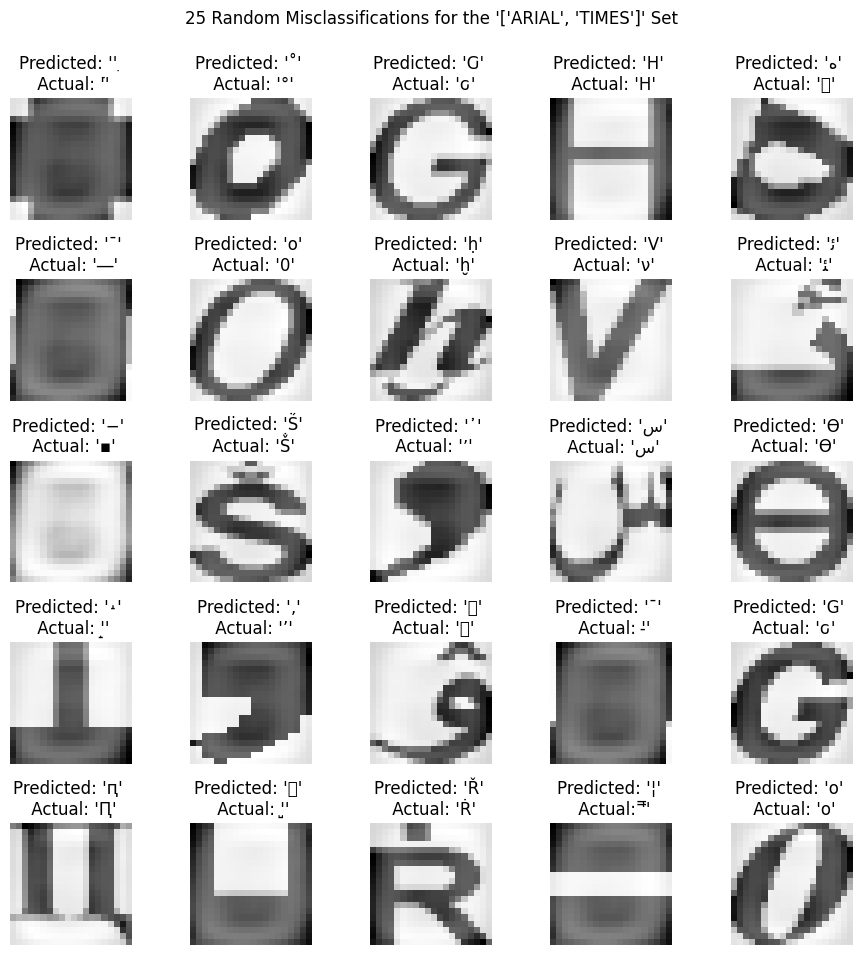

/var/folders/lq/1xkr9wc516j_pqbd780s6s0w0000gn/T/ipykernel_14004/1632906850.py:195: UserWarning: Glyph 1771 (\N{ARABIC EMPTY CENTRE HIGH STOP}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/lq/1xkr9wc516j_pqbd780s6s0w0000gn/T/ipykernel_14004/1632906850.py:195: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/lq/1xkr9wc516j_pqbd780s6s0w0000gn/T/ipykernel_14004/1632906850.py:195: UserWarning: Glyph 2301 (\N{ARABIC RIGHT ARROWHEAD ABOVE WITH DOT}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/lq/1xkr9wc516j_pqbd780s6s0w0000gn/T/ipykernel_14004/1632906850.py:195: UserWarning: Glyph 7558 (\N{LATIN SMALL LETTER M WITH PALATAL HOOK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/Users/u0858882/Desktop/6017/assignments/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: 

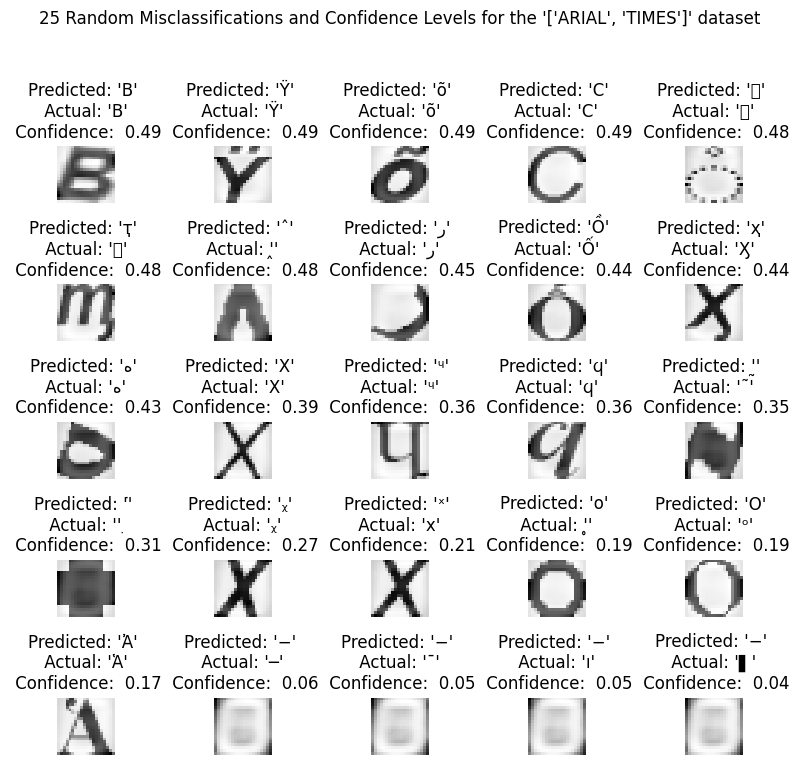

In [219]:
font_multiple.show_misclassifications()
font_multiple.show_low_confidences()

## ConvolutionalAutoencoder

In [220]:
class ConvolutionalAutoencoder(nn.Module):    
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()

        self.color_channels = 1
        self.c1Out = 8
        self.c2Out = 8
        self.encodedSize = 32
        matchy = 64

        # We add padding, so the conv2d layers don't change the size, just the max pools.
        self.downscaledSize = 20//4
        self.flattenedSize = self.c2Out * (self.downscaledSize * self.downscaledSize)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

        # The padding here puts a "border" of 0s around the image, so that convolution layers don't "shrink" the image.
        self.cv1 = nn.Conv2d(self.color_channels, self.c1Out, kernel_size=3, padding=1)
        self.cv2 = nn.Conv2d(self.c1Out, self.c2Out, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(self.flattenedSize, matchy)
        self.fc2 = nn.Linear(matchy, self.encodedSize) #scale down to 64 features
        #now we're encoded, so go define decoding pieces
        self.fc3 = nn.Linear(self.encodedSize, matchy) #scale up to 64 features
        self.fc4 = nn.Linear(matchy, self.flattenedSize)

        # The padding is very important here so we don't have to guess a "frame" of pixels around the image.
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, kernel_size=3, padding=1)
        self.cv4 = nn.Conv2d(self.c1Out, self.color_channels, kernel_size=3, padding=1)

    def compress(self, x):
        # print("[C] At start:\t\t", x.shape)

        x = self.cv1(x)
        # print("[C] After conv1:\t", x.shape)

        x = F.relu(self.pool(x))
        # print("[C] After pool1:\t", x.shape)

        x = self.cv2(x)
        # print("[C] After conv2:\t", x.shape)

        x = F.relu(self.pool(x))
        # print("[C] After pool2:\t", x.shape)

        x = x.view(-1, self.flattenedSize)
        # print("[C] After flat:\t\t", x.shape)

        x = F.relu(self.fc1(x))
        # print("[C] After fc1:\t\t", x.shape)

        x = F.relu(self.fc2(x))
        # print("[C] After fc1:\t\t", x.shape)

        # Now we have a low-d representation of our data.  If we were doing compression, we'd store this.
        return x
    
    def decompress(self, x):

        x = F.relu(self.fc3(x))
        # print("[D] After fc3:\t\t", x.shape)

        x = F.relu(self.fc4(x))
        # print("[D] After fc4:\t\t", x.shape)

        x = x.view(-1, self.c2Out, self.downscaledSize, self.downscaledSize)
        # print("[D] After unflat:\t", x.shape)

        x = self.upsample(x)
        # print("[D] After up1:\t\t", x.shape)

        x = F.relu(self.cv3(x))
        # print("[D] After conv3:\t", x.shape)

        x = self.upsample(x)
        # print("[D] After up2:\t\t", x.shape)

        x = self.cv4(x)
        # print("[D] After conv4:\t", x.shape, "\n")

        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)
        return x

## trainAutoencoder()

In [221]:
def trainAutoencoder(model, font: FontDataset, epochs):
    if gpu:
        dataloader = DataLoader(font.train_set_noisy, batch_size=batch_size, 
						        shuffle=True, num_workers=0, 
								collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    else:
        dataloader = DataLoader(font.train_set_noisy, batch_size=batch_size, 
						        shuffle=True, num_workers=0)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        loss = 0
        running_loss = 0
        for i, data in enumerate(dataloader, 0):

            # Same as yesterday, except we're not even looking at the labels!
            # Since we're not using a CNN, we need to "flatten" the input images.
            batch_features = data[0]

            optimizer.zero_grad()
        
            # Compute reconstructions.
            outputs = model(batch_features)
            #print(batch_features.shape)
            #print(outputs.shape)

            # Compute training reconstruction loss.
            # Again, same idea as yesterday, but we're measuring the error slightly differently.
            # How well does the reconstructed image match the input image?
            train_loss = loss_function_autoencoder(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
        
            # Add the mini-batch training loss to epoch loss
            loss += train_loss.item()
    
             # Print every 2000 mini-batches
            running_loss += train_loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.8f' % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

        # compute and display the epoch training loss
        loss = loss / len(dataloader)
        print("Epoch : {}/{} | Loss = {:.8f}".format(epoch+1, epochs, loss))

## evaluateAutoencoder()

In [222]:
def evaluateAutoencoder(model, font: FontDataset):
    if gpu:
        dataloader = DataLoader(font.test_set_noisy, batch_size=batch_size, 
						        shuffle=True, num_workers=0, 
								collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    else:
        dataloader = DataLoader(font.test_set_noisy, batch_size=batch_size, 
						        shuffle=True, num_workers=0)

    total_loss = 0
    with torch.no_grad():
        for data in dataloader:
            images = data[0]
            outputs = model(images)
            test_loss = loss_function_autoencoder(outputs, images)
            total_loss += test_loss.item()
    print("Overall loss:\t", total_loss)

## drawComparisons()

In [223]:
def drawComparisonsCNN(model, font: FontDataset):
    if gpu:
        dataloader = DataLoader(font.test_set, batch_size=batch_size, 
						        shuffle=True, num_workers=0, 
								collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    else:
        dataloader = DataLoader(font.test_set, batch_size=batch_size, 
						        shuffle=True, num_workers=0)

    plt.figure(figsize=(20, 6))
    for i, batch in enumerate(dataloader):
        if i >= 8: break
        images = batch[0]
        #print(images.shape)
        with torch.no_grad():
            reconstructed = model(images)
            for j in range(len(images)):

                # Draw the original image.
                ax = plt.subplot(16, 8, i*16 + j + 1)
                plt.imshow(np.reshape(images[j], (20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
                # Draw the reconstructed version in the next row.
                ax = plt.subplot(16, 8, i*16 + j + 1 + 8)
                plt.imshow(np.reshape(reconstructed[j], (20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

## Step 4: Denoising Images using a Convolutional Autoencoder

Device:			 'cpu' 
Font:			 ARIAL 
Num total samples:	 26237 
Num training samples:	 20989 
Num testing samples:	 5248
[1,  2000] loss: 0.00032943
Epoch : 1/8 | Loss = 0.69616381
[2,  2000] loss: 0.00029975
Epoch : 2/8 | Loss = 0.62475917
[3,  2000] loss: 0.00030881
Epoch : 3/8 | Loss = 0.61287010
[4,  2000] loss: 0.00031671
Epoch : 4/8 | Loss = 0.60906471
[5,  2000] loss: 0.00034779
Epoch : 5/8 | Loss = 0.60660493
[6,  2000] loss: 0.00029112
Epoch : 6/8 | Loss = 0.60486863
[7,  2000] loss: 0.00031155
Epoch : 7/8 | Loss = 0.60332395
[8,  2000] loss: 0.00030828
Epoch : 8/8 | Loss = 0.60175894
Overall loss:	 395.2749158143997


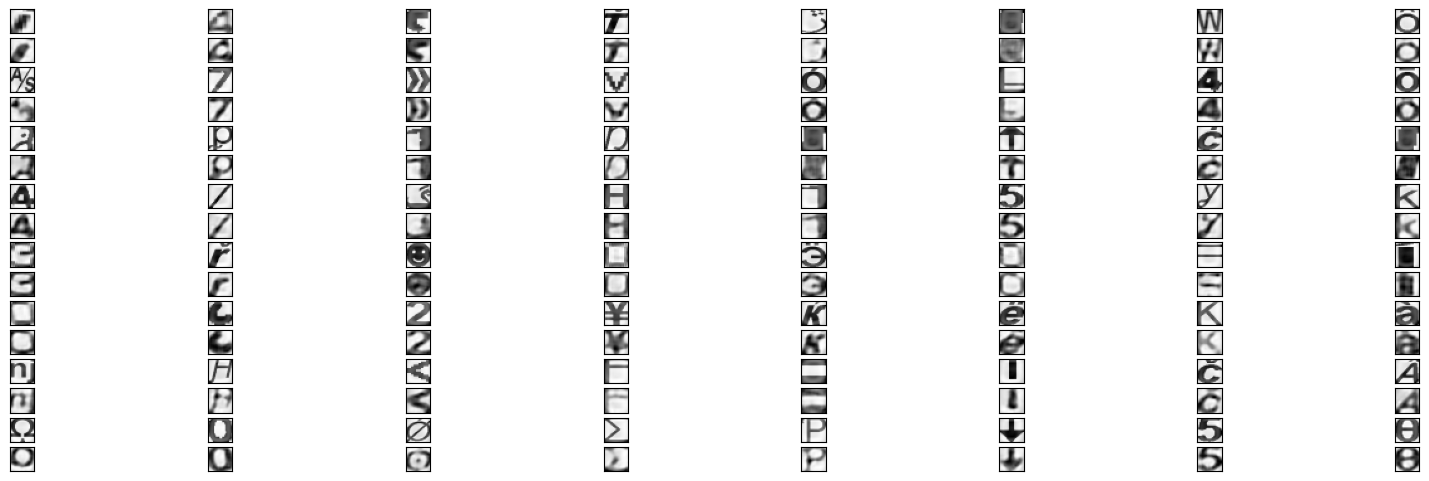

In [224]:
font_autoencoder = FontDataset("ARIAL")

autoencoder = ConvolutionalAutoencoder().to(device=device)

print("Device:\t\t\t", f"'{device}'",
	  "\nFont:\t\t\t", font_autoencoder.fonts,
	  "\nNum total samples:\t", font_autoencoder.num_samples_total,
	  "\nNum training samples:\t", font_autoencoder.num_samples_train,
	  "\nNum testing samples:\t", font_autoencoder.num_samples_test)

trainAutoencoder(autoencoder, font_autoencoder, epochs=epochs)
evaluateAutoencoder(autoencoder, font_autoencoder)

drawComparisonsCNN(autoencoder, font_autoencoder)

### Analysis

Did not seem to do as well on these character datasets as it did on the MNIST set, but still pretty cool. The integrity of the reconstruction seemed to have a lot to do with the complexity of the character.
+ e.g. monolithic shapes like a capital 'I' did ok (i.e. they were recognizable from the construction), but a fancy capital 'C' or lowercase 'a' usually turned out as a blob. 
+ Lots of greyness/blurriness in these compared to even the MNSIT dataset